In [54]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math

In [55]:
earth_mass = 5.97e24 # kg
earth_radius = 6.378e6 # m (at equator)
gravitational_constant = 6.67e-11 # m3 / kg s2
moon_mass = 7.35e22 # kg
moon_radius = 1.74e6 # m
moon_distance = 400.5e6 # m (actually, not at all a constant)
moon_period = 27.3 * 24.0 * 3600. # s
moon_initial_angle = math.pi / 180. * -61. # radian

total_duration = 1 *12. * 24. * 3600. # s
marker_time = 0.5 * 3600. # s
tolerance = 100000. # m

In [56]:
def moon_position(time):
# Task 1: Compute the moon's position (a vector) at time t. Let it start at moon_initial_angle, not on the horizontal axis.   
    ###Your code here.
    position = np.zeros(2)
    moon_angle = moon_initial_angle + 2 * math.pi * time/moon_period 
    position[0] = moon_distance * math.cos(moon_angle)
    position[1] = moon_distance * math.sin(moon_angle)
    return position

In [57]:
def acceleration(time, position):
# Task 2: Compute the spacecraft's acceleration due to gravity
	###Your code here.
    moon_pos = moon_position(time)
    moon_vector = position - moon_pos
    earth_vector = position
    acc = - gravitational_constant * earth_mass * earth_vector/np.linalg.norm(earth_vector)**3 - \
            gravitational_constant * moon_mass * moon_vector/np.linalg.norm(moon_vector)**3
    return acc  

Text(0, 0.5, 'Lateral position in m')

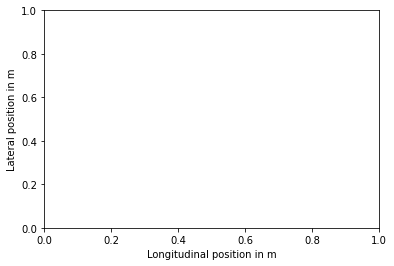

In [58]:
axes = plt.gca()
axes.set_xlabel('Longitudinal position in m')
axes.set_ylabel('Lateral position in m')


In [63]:
def apply_boost():

    # Do not worry about the arrays position_list, velocity_list, and times_list.  
    # They are simply used for plotting and evaluating your code, so none of the 
    # code that you add should involve them.
    
    boost = 10. # m/s Change this to the correct value from the list above after everything else is done.
    position_list = [np.array([-6.701e6, 0.])] # m
    velocity_list = [np.array([0., -10.818e3])] # m / s
    times_list = [0]
    position = position_list[0]
    velocity = velocity_list[0]
    current_time = 0.
    h = 0.1 # s, set as initial step size right now but will store current step size
    h_new = h # s, will store the adaptive step size of the next step
    mcc2_burn_done = False
    dps1_burn_done = False

    while current_time < total_duration:
        #Task 3: Include a retrograde rocket burn at 101104 seconds that reduces the velocity by 7.04 m/s
        # and include a rocket burn that increases the velocity at 212100 seconds by the amount given in the variable called boost.
        # Both velocity changes should happen in the direction of the rocket's motion at the time they occur.
        
        ###Your code here.
        if mcc2_burn_done is False and current_time >= 101104:
            velocity -= 7.04 * velocity / np.linalg.norm(velocity)
            plt.scatter(position[0], position[1], s = 16., facecolor = 'g', edgecolor = 'none')
            mcc2_burn_done = True
        
        if dps1_burn_done is False and current_time >= 212100:
            velocity += boost * velocity / np.linalg.norm(velocity)
            plt.scatter(position[0], position[1], s = 16., facecolor = 'g', edgecolor = 'none')
            dps1_burn_done = True
        #Task 4: Implement Heun's method with adaptive step size. Note that the time is advanced at the end of this while loop.
        ###Your code here.
        _acc = acceleration(current_time, position)
        velocityE = velocity + h * _acc
        positionE = position + h * velocityE
        velocityH = velocity + h * 0.5 * (acceleration(current_time + h, positionE) + _acc)
        positionH = position + h * 0.5 * (velocity + velocityE)
        velocity = velocityH
        position = positionH
        ###Your code here.
        error = np.linalg.norm(positionE - positionH) + total_duration * np.linalg.norm(velocityE - velocityH)
        h_new = h * math.sqrt(tolerance/error)
        h_new = min(0.5 * marker_time, max(0.1, h_new)) # restrict step size to reasonable range
            
        current_time += h
        h = h_new
        position_list.append(position.copy())
        velocity_list.append(velocity.copy())
        times_list.append(current_time)

    return position_list, velocity_list, times_list, boost

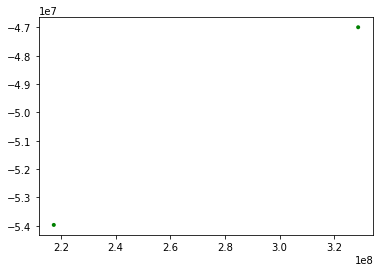

In [64]:
position, velocity, current_time, boost = apply_boost()


In [65]:
def plot_path(position_list, times_list):
    axes = plt.gca()
    axes.set_xlabel('Longitudinal position in m')
    axes.set_ylabel('Lateral position in m')
    previous_marker_number = -1;
    for position, current_time in zip(position_list, times_list):
         if current_time >= marker_time * previous_marker_number:
            previous_marker_number += 1
            plt.scatter(position[0], position[1], s = 2., facecolor = 'r', edgecolor = 'none')
            moon_pos = moon_position(current_time)
            if np.linalg.norm(position - moon_pos) < 30. * moon_radius: 
                axes.add_line(matplotlib.lines.Line2D([position[0], moon_pos[0]], [position[1], moon_pos[1]], alpha = 0.3, c = 'g')) 
    axes.add_patch(matplotlib.patches.CirclePolygon((0., 0.), earth_radius, facecolor = 'none', edgecolor = 'b'))
    for i in range(int(total_duration / marker_time)):
        moon_pos = moon_position(i * marker_time)
        axes.add_patch(matplotlib.patches.CirclePolygon(moon_pos, moon_radius, facecolor = 'none', edgecolor = 'g', alpha = 0.7))

    plt.axis('equal')

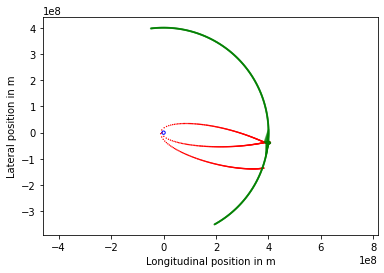

In [66]:
plot_path(position, current_time)
